<a href="https://colab.research.google.com/github/sruthib22/data690fall21/blob/main/DAA_Mid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import numpy as np
import math
from skimage import io, util
import heapq
import sklearn

In [69]:
# Python program for finding min-cut in the given graph 
# Complexity : (E*(V^3)) 
# Total augmenting path = VE and BFS 
# with adj matrix takes :V^2 times 
  
from collections import defaultdict 
  
# This class represents a directed graph
# using adjacency matrix representation 
class Graph_Cut: 
  
    def __init__(self,graph): 
        self.graph = graph
        self.org_graph = [i[:] for i in graph] 
        self. Row = len(graph) 
        self.Col = len(graph[0]) 
  
  
    '''Returns true if there is a path from 
    source 's' to sink 't' in 
    residual graph. Also fills 
    parent[] to store the path '''
    def BFS(self,s, t, k, parent): 
        
        
        # Mark all the vertices as not visited 
        visited =[False]*(self.Row) 
  
        # Create a queue for BFS 
        queue=[] 
  
        # Mark the source node as visited and enqueue it 
        queue.append(s) 
        visited[s] = True
  
        # Standard BFS Loop 
        while queue: 
  
            #Dequeue a vertex from queue and print it 
            u = queue.pop(0) 
  
            # Get all adjacent vertices of 
            # the dequeued vertex u 
            # If a adjacent has not been
            # visited, then mark it 
            # visited and enqueue it 
            for ind, val in enumerate(self.graph[u]): 
                if visited[ind] == False and val > 0 : 
                    queue.append(ind) 
                    visited[ind] = True
                    parent[ind] = u 
  
        # If we reached sink in BFS starting
        # from source, then return 
        # true, else false 
        return True if visited[t] else False
          
    # Function for Depth first search 
    # Traversal of the graph
    def dfs(self, graph,s,visited):
        visited[s]=True
        for i in range(len(graph)):
            if graph[s][i]>0 and not visited[i]:
                self.dfs(graph,i,visited)
  
    # Returns the min-cut of the given graph 
    def minCut(self,source, sink, s): 
  
        # This array is filled by BFS and to store path 
        parent = [-1]*(self.Row) 
  
        max_flow = 0 # There is no flow initially 
  
        # Augment the flow while there is path from source to sink 
        while self.BFS(source, sink, s, parent) : 
  
            # Find minimum residual capacity of the edges along the 
            # path filled by BFS. Or we can say find the maximum flow 
            # through the path found. 
            path_flow = float("Inf") 
            s = sink
            #print("Sink",s,sink,source)
            while(s != source): 
                path_flow = min (path_flow, self.graph[parent[s]][s]) 
                s = parent[s] 
  
            # Add path flow to overall flow 
            max_flow += path_flow 
  
            # update residual capacities of the edges and reverse edges 
            # along the path 
            v = sink 
            while(v != source): 
                u = parent[v] 
                self.graph[u][v] -= path_flow 
                self.graph[v][u] += path_flow 
                v = parent[v] 
  
        visited=len(self.graph)*[False]
        #print("S",s)
        self.dfs(self.graph,s,visited)
  
        # print the edges which initially had weights 
        # but now have 0 weight 
        left_image = []
        right_image = []
        
        for i in range(self.Row): 
            for j in range(self.Col): 
                if self.graph[i][j] == 0 and\
                self.org_graph[i][j] > 0 and visited[i]:
                    left_image .append(i)
                    right_image.append(j)
                    #print (str(i) + " - " + str(j))
                    
        return left_image,right_image

In [70]:
def rand_patch(texture, patchLength):
    h, w, _ = texture.shape
    i = np.random.randint(h - patchLength)
    j = np.random.randint(w - patchLength)

    return texture[i:i+patchLength, j:j+patchLength]

In [71]:
def Best_patch_rand(texture, patchLength, overlap, res, y, x):
    
    h, w, _ = texture.shape
    errors = np.zeros((h - patchLength, w - patchLength))

    for i in range(h - patchLength):
        for j in range(w - patchLength):
            patch = texture[i:i+patchLength, j:j+patchLength]
            e = L2OverlapDiff(patch, patchLength, overlap, res, y, x)
            errors[i, j] = e

    i, j = np.unravel_index(np.argmin(errors), errors.shape)
    return texture[i:i+patchLength, j:j+patchLength]

In [72]:
def L2OverlapDiff(patch, patchLength, overlap, res, y, x):
    error = 0

    if x > 0:
        left = patch[:, :overlap] - res[y:y+patchLength, x:x+overlap]
        error += np.sum(left**2)

    if y > 0:
        up   = patch[:overlap, :] - res[y:y+overlap, x:x+patchLength]
        error += np.sum(up**2)

    if x > 0 and y > 0:
        corner = patch[:overlap, :overlap] - res[y:y+overlap, x:x+overlap]
        error -= np.sum(corner**2)

    return error

In [73]:
import matplotlib.pyplot as plt2
def minCutPatch(patch, patchLength, overlap, res, y, x,texture):

    patch_copy = patch.copy()
    res_copy = res.copy()
    
    
    if y > 0:
        patch_right = res_copy[x:x+patchLength,y:y+overlap]
        patch_left = patch_copy[:,:overlap]
      
        totalNodes = (len(patch_right) * len(patch_right[0]))+2
        
        #initiating the adj matrix
        matrix = []
        for i in range(0,(len(patch_right) * len(patch_right[0]))+2):
            rows = []
            for j in range(0,(len(patch_right) * len(patch_right[0]))+2):
                rows.append(0)
            matrix.append(rows)
    
#         print("Matrix shape",len(matrix),len(matrix[0]))

        #assigning infinities

        for i in range(1,len(patch_right)+1):
            #print("Assigning inf from 0",i)
            matrix[0][i] = float('inf')
        for i in range(25*(overlap-1)+1,totalNodes-1):
            #print("Assigning inf from ",i,totalNodes-1)
            matrix[i][totalNodes-1] = float('inf')



        cols = len(patch_right)
        for i in range(1,patchLength+1):
            prev = i
            for j in range(0,overlap):
                if(j+1<overlap):
                    
                    matrix[prev][prev+cols] = getAvg(abs(patch_left[i-1][j] - patch_right[i-1][j]) + abs(patch_left[i-1][j+1] - patch_right[i-1][j+1]))

                if(i < patchLength):
                   
                    matrix[prev][prev+1] = getAvg(abs(patch_left[i-1][j] - patch_right[i-1][j]) + abs(patch_left[i][j] - patch_right[i][j]))
                prev = prev+cols


        #print(matrix)

        graph = matrix

        g = Graph_Cut(matrix) 

        source = 0; sink = 101
        s = 101

        left_pixels ,right_pixels = g.minCut(source, sink, s)

        for i in range(0,len(left_pixels)):
            print(left_pixels[i],right_pixels[i]) 
        
        pixelsFromLeft = set()
        pixelsFromRight = set()
       
        
        for i in range(0,len(left_pixels)):
            #vertical cut
            if right_pixels[i] != left_pixels[i]+1:
                
                row = left_pixels[i] % 25
                if(row == 0):
                    row = 25
                ctr = 0
                #print("Row",row)
                #all nodes to the left of the cut in the row will be from left hand side
                for j in range(row,left_pixels[i]+1):
                    pixelsFromLeft.add(j)
                    ctr +=1
                
                #all nodes to the right of the cut in the row will be from right hand side
                j = right_pixels[i]
                while(ctr<overlap):
                    pixelsFromRight.add(j)
                    j = j+25
                    ctr+=1
    
        print("left",pixelsFromLeft)
        print("Right",pixelsFromRight)
        
#         if(len(pixelsFromLeft)) == 0:
#             print("Left Zerdo--------------------------------------------------------------------------------")
#         if(len(pixelsFromRight)) == 0:
#             print("Right Zerdo--------------------------------------------------------------------------------")
        counter = 1
        
        for j in range(0,overlap):
            for i in range(0,patchLength):
                
                if counter in pixelsFromLeft:
                    #print("---------------------------------------------------------- replacing left")
                    patch[i][j] = patch_left[i][j]
                    counter+=1
                
        
        minCutMatrix = []
        for i in range(0,patchLength):
            colorsRow = []
            for j in range(0,overlap):
                print("MAPPING",i+1+(j*patchLength))
                if i+1+(j*patchLength) in pixelsFromLeft:
                    colorsRow.append(1)
                else:
                    colorsRow.append(2)
            minCutMatrix.append(colorsRow)
                    
                    
        fig, ax = plt.subplots()
        ax.matshow(minCutMatrix, cmap='ocean')
        plt.show()
        
        
        
    
    if x > 0 :
        #lets define two sets
        matrix = []
#         print(x,x+overlap)
        patch_up = res_copy[((x)):(x+overlap),y:y+patchLength]
        patch_bottom = patch_copy[:overlap,:]
#         print(patch_up.shape)
#         print(patch_bottom.shape)
        
        print("Patch Up",patch_up)
        print("Patch bottom",patch_bottom)
        
        for i in range(0,(len(patch_up) * len(patch_up[0]))+2):
            rows = []
            for j in range(0,(len(patch_up) * len(patch_up[0]))+2):
                rows.append(0)
            matrix.append(rows)
    
        #print("Matrix shape",len(matrix),len(matrix[0]))

        #assigning infinities

        for i in range(1,len(patch_up)+1):
            #print("Assigning inf from 0",i)
            matrix[0][i] = float('inf')
        for i in range(97,101):
            #print("Assigning inf from ",i,totalNodes-1)
            matrix[i][101] = float('inf')



        cols = len(patch_up)
        #print("Cols in x >0",cols)
        for i in range(1,overlap+1):
            prev = i
            for j in range(0,patchLength):
                if(j+1<patchLength): 
                    if(getAvg(patch_up[i-1][j])  == getAvg(patch_bottom[i-1][j]) and getAvg(patch_up[i-1][j+1]) == getAvg(patch_bottom[i-1][j+1])):
                        print("They are the same idiot")
                    matrix[prev][prev+cols] = getAvg(abs(patch_up[i-1][j] - patch_bottom[i-1][j]) + abs(patch_up[i-1][j+1] - patch_bottom[i-1][j+1]))

                if(i < overlap):        
                    if(getAvg(patch_up[i-1][j])  == getAvg(patch_bottom[i-1][j]) and getAvg(patch_up[i][j]) == getAvg(patch_bottom[i][j])):
                        print("They are the same idiot")
                    matrix[prev][prev+1] = getAvg(abs(patch_up[i-1][j] - patch_bottom[i-1][j]) + abs(patch_up[i][j] - patch_bottom[i][j]))
                prev = prev+cols


        #print(matrix)

        graph = matrix

        g = Graph_Cut(matrix) 

        source = 0; sink = 101
        s=101
        left_pixels ,right_pixels = g.minCut(source, sink, s)

        for i in range(0,len(left_pixels)):
            print(left_pixels[i],right_pixels[i]) 
        
        pixelsFromUp = set()
        pixelsFromBottom = set()
       
        
        for i in range(0,len(left_pixels)):
            #horizontal cut
            if right_pixels[i] == left_pixels[i]+1:
                
                row = left_pixels[i] % 4
                if(row == 0):
                    row = 4
                column =(int) (min(left_pixels[i] /4,right_pixels[i]/4))
                ctr = 0
                #print("Row",row)
                #all nodes to the up of the cut in the column will be from up
                for j in range((column*4)+1,left_pixels[i]+1):
                    pixelsFromUp.add(j)
                    ctr +=1
                
                #all nodes to the bottom of the cut in the cokumn will be from down
                j = right_pixels[i]
                while(ctr<overlap):
                    pixelsFromBottom.add(j)
                    j = j+1
                    ctr+=1
    
#         print("UP",pixelsFromUp)
#         print("Bottom",pixelsFromBottom)
        
        counter = 1
        for j in range(0,patchLength):
            for i in range(0,overlap):
                if counter in pixelsFromUp:
                    #print("---------------------------------------------------------- replacing up")
                    patch[i][j] = patch_up[i][j]
                    counter += 1
        
        minCutMatrix = []
        for i in range(0,overlap):
            colorsRow = []
            for j in range(0,patchLength):
                print("MAPPING - UP",i+1+(j*overlap))
                if i+1+(j*overlap) in pixelsFromUp:
                    colorsRow.append(1)
                else:
                    colorsRow.append(2)
            minCutMatrix.append(colorsRow)
                    
                    
        fig, ax = plt.subplots()
        ax.matshow(minCutMatrix, cmap='ocean')
        plt.show()
     
    #print("REACHED LAST",patch)
#     io.imshow(patch)
#     io.show()

    return patch

In [74]:
successfulPatch = []

In [75]:
def quilt(texture, patchLength, numPatches, mode="cut", sequence=True):
    texture = util.img_as_float(texture)
    
    overlap = patchLength // 6
    #print("Overlapped region",overlap)
    numPatchesHigh, numPatchesWide = numPatches
    
    h = (numPatchesHigh * patchLength) - (numPatchesHigh - 1) * overlap
    w = (numPatchesWide * patchLength) - (numPatchesWide - 1) * overlap
    
    #print("height and width",h,w)
    #print("Texture shape",texture.shape[2])
    
    res = np.zeros((h, w, texture.shape[2]))
    
    #print("Res",res.shape)

    for i in range(numPatchesHigh):
        for j in range(numPatchesWide):
            x = i * (patchLength - overlap)
            y = j * (patchLength - overlap)
            print("X",x)
            print("Y",y)
            if i == 0 and j == 0 or mode == "random":
                patch = rand_patch(texture, patchLength)
                successfulPatch = patch
            elif mode == "best":
                patch = Best_patch_rand(texture, patchLength, overlap, res, y, x)
            elif mode == "cut":
                patch = Best_patch_rand(texture, patchLength, overlap, res, y, x)
                patch = minCutPatch(patch, patchLength, overlap, res, y, x,texture)
            
            res[y:y+patchLength,x:x+patchLength] = patch

            if sequence:
                io.imshow(res)
                io.show()
      
    return res

In [76]:
def getAvg(pixelArray):
    return (sum(pixelArray)/3)

X 0
Y 0


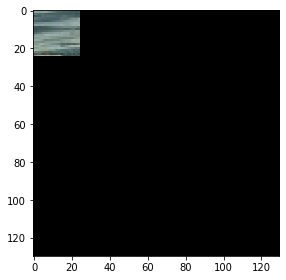

X 0
Y 21
1 26
2 27
3 28
4 29
5 30
6 31
13 38
20 45
21 46
24 49
34 59
36 61
38 63
41 66
42 67
45 70
46 71
47 72
48 73
57 82
58 83
59 84
60 85
61 86
62 87
63 88
64 89
65 90
66 91
67 92
68 93
69 94
70 95
71 96
72 97
73 98
74 99
75 100
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Right {26, 27, 28, 29, 30, 31, 38, 45, 46, 49, 51, 52, 53, 54, 55, 56, 63, 70, 71, 74, 76, 77, 78, 79, 80, 81, 88, 95, 96, 99}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 54
MAPPING 79
MAPPING 5
MAPPING 30
MAPPING 55
MAPPING 80
MAPPING 6
MAPPING 31
MAPPING 56
MAPPING 81
MAPPING 7
MAPPING 32
MAPPING 57
MAPPING 82
MAPPING 8
MAPPING 33
MAPPING 58
MAPPING 83


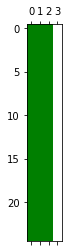

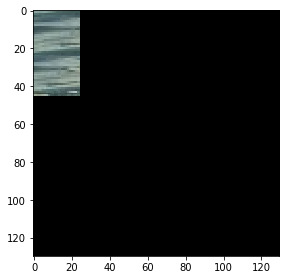

X 0
Y 42
1 26
2 27
3 28
4 29
5 30
6 31
7 32
8 33
9 34
10 35
11 36
12 37
13 38
14 39
15 40
16 41
17 42
18 43
19 44
20 45
22 47
23 48
24 49
25 50
48 73
49 74
71 96
72 97
73 98
74 99
75 100
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Right {26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 54
MAPPING 79
MAPPING 5
MAPPING 30
MAPPING 55
MAPPING 80
MAPPI

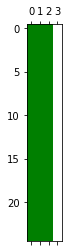

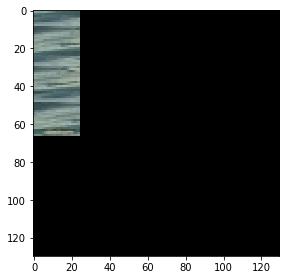

X 0
Y 63
1 26
2 27
3 28
4 29
5 30
6 31
7 32
8 33
9 34
10 35
11 36
12 37
13 38
14 39
20 45
24 49
25 50
40 65
45 70
46 71
49 74
50 75
66 91
67 92
68 93
69 94
70 95
71 96
72 97
73 98
74 99
75 100
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Right {26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 45, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 70, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 95, 99, 100}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 54
MAPPING 79
MAPPING 5
MAPPING 30
MAPPING 55
MAPPING 80
MAPPING 6
MAPPING 31
MAPPING 56
MAPPING 81
MAPPING 7
MAPPING 32
MAPPING 57
MAPPING 

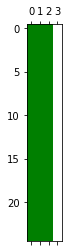

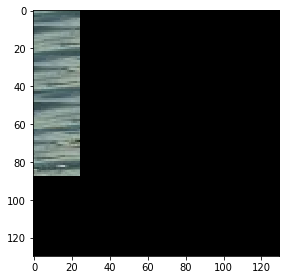

X 0
Y 84
1 26
2 27
3 28
4 29
5 30
6 31
7 32
8 33
9 34
10 35
11 36
12 37
13 38
14 39
15 40
16 41
22 47
24 49
42 67
43 68
49 74
50 75
69 94
70 95
71 96
72 97
73 98
74 99
75 100
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Right {26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 47, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 72, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 97, 99}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 54
MAPPING 79
MAPPING 5
MAPPING 30
MAPPING 55
MAPPING 80
MAPPING 6
MAPPING 31
MAPPING 56
MAPPING 81
MAPPING 7
MAPPING 32
MAPPING 57
MAPPING 82
MAPP

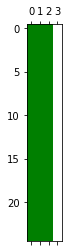

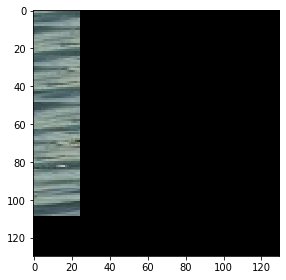

X 0
Y 105
1 26
2 27
3 28
4 29
5 30
6 31
8 33
10 35
11 36
12 37
13 38
14 39
15 40
16 41
17 42
18 43
19 44
22 47
24 49
32 57
33 58
34 59
35 60
37 62
38 63
39 64
40 65
41 66
42 67
43 68
44 69
45 70
46 71
47 72
48 73
49 74
61 86
62 87
63 88
64 89
65 90
66 91
67 92
68 93
69 94
70 95
71 96
72 97
73 98
74 99
75 100
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Right {26, 27, 28, 29, 30, 31, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 47, 49, 51, 52, 53, 54, 55, 56, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 72, 74, 76, 77, 78, 79, 80, 81, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 97, 99}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 

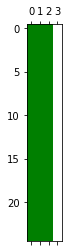

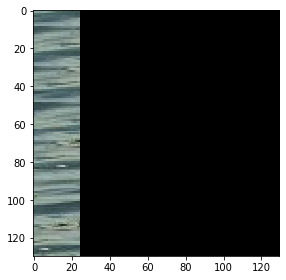

X 21
Y 0
Patch Up [[[0.5372549  0.61960784 0.59215686]
  [0.55294118 0.63529412 0.60784314]
  [0.57647059 0.65882353 0.63137255]
  [0.6        0.68235294 0.65490196]
  [0.60392157 0.68627451 0.65882353]
  [0.58823529 0.67058824 0.64313725]
  [0.56470588 0.65490196 0.62352941]
  [0.56470588 0.65490196 0.63137255]
  [0.54901961 0.64705882 0.62352941]
  [0.52156863 0.61960784 0.59607843]
  [0.48627451 0.58431373 0.56078431]
  [0.45882353 0.55686275 0.53333333]
  [0.43529412 0.53333333 0.50980392]
  [0.40392157 0.50196078 0.47843137]
  [0.37647059 0.4745098  0.45098039]
  [0.36862745 0.46666667 0.44313725]
  [0.34901961 0.44705882 0.42352941]
  [0.3254902  0.42352941 0.4       ]
  [0.31372549 0.41176471 0.38823529]
  [0.31764706 0.41568627 0.39215686]
  [0.32156863 0.41960784 0.39607843]
  [0.31764706 0.41568627 0.39215686]
  [0.30980392 0.40784314 0.38431373]
  [0.30588235 0.40392157 0.38039216]
  [0.33333333 0.42352941 0.39215686]]

 [[0.50980392 0.60784314 0.59215686]
  [0.47058824 0.56

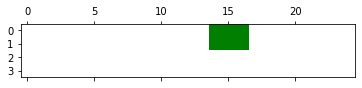

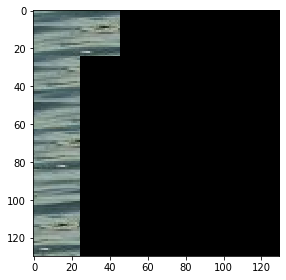

X 21
Y 21
25 50
26 51
27 52
28 53
50 75
54 79
72 97
73 98
74 99
75 100
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Right {50, 75, 100}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 54
MAPPING 79
MAPPING 5
MAPPING 30
MAPPING 55
MAPPING 80
MAPPING 6
MAPPING 31
MAPPING 56
MAPPING 81
MAPPING 7
MAPPING 32
MAPPING 57
MAPPING 82
MAPPING 8
MAPPING 33
MAPPING 58
MAPPING 83
MAPPING 9
MAPPING 34
MAPPING 59
MAPPING 84
MAPPING 10
MAPPING 35
MAPPING 60
MAPPING 85
MAPPING 11
MAPPING 36
MAPPING 61
MAPPING 86
MAPPING 12
MAPPING 37
MAPPING 62
MAPPING 87
MAPPING 13
MAPPING 38
MAPPING 63
MAPPING 88
MAPPING 14
MAPPING 39
MAPPING 64
MAPPING 89
MAPPI

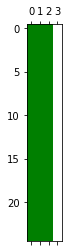

Patch Up [[[0.28627451 0.38039216 0.38039216]
  [0.32941176 0.41176471 0.41568627]
  [0.3254902  0.40784314 0.41176471]
  [0.28627451 0.36470588 0.36862745]
  [0.30588235 0.38431373 0.38823529]
  [0.31764706 0.38823529 0.39607843]
  [0.29019608 0.36078431 0.36862745]
  [0.29019608 0.34901961 0.36078431]
  [0.23529412 0.30588235 0.31372549]
  [0.25490196 0.33333333 0.3372549 ]
  [0.24313725 0.3254902  0.32941176]
  [0.24705882 0.32941176 0.33333333]
  [0.27058824 0.35294118 0.35686275]
  [0.28235294 0.36470588 0.37647059]
  [0.2745098  0.35686275 0.36862745]
  [0.25098039 0.33333333 0.34509804]
  [0.23137255 0.31372549 0.3254902 ]
  [0.19607843 0.27843137 0.29803922]
  [0.22745098 0.30980392 0.32941176]
  [0.25882353 0.34117647 0.36078431]
  [0.25882353 0.34117647 0.36078431]
  [0.23529412 0.31764706 0.3372549 ]
  [0.21176471 0.29411765 0.31372549]
  [0.20392157 0.28235294 0.30980392]
  [0.21176471 0.29019608 0.31764706]]

 [[0.31372549 0.4        0.39215686]
  [0.28627451 0.36470588 0.

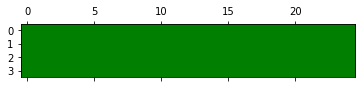

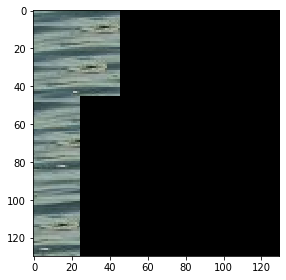

X 21
Y 42
1 26
2 27
3 28
4 29
6 31
7 32
8 33
9 34
10 35
16 41
17 42
18 43
19 44
20 45
25 50
31 56
33 58
35 60
37 62
38 63
42 67
43 68
44 69
45 70
48 73
55 80
56 81
57 82
58 83
59 84
60 85
61 86
62 87
63 88
64 89
65 90
66 91
67 68
67 92
71 96
72 97
73 98
74 99
75 100
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Right {26, 27, 28, 29, 31, 32, 33, 34, 35, 41, 42, 43, 44, 45, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 66, 67, 68, 69, 70, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 91, 92, 93, 94, 95, 100}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 54
MAPPING 79
MAPPING 5
MAPPING 30
MAPPING 55
MAPPING 80
MAPPING 6
MAPPING 31
MAPPING 56
M

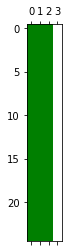

Patch Up [[[0.34509804 0.41960784 0.41176471]
  [0.34901961 0.42352941 0.41568627]
  [0.35686275 0.43529412 0.42745098]
  [0.38431373 0.4627451  0.45490196]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.30980392 0.38823529 0.39215686]
  [0.31372549 0.39215686 0.

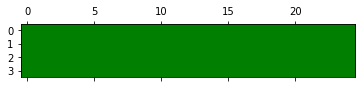

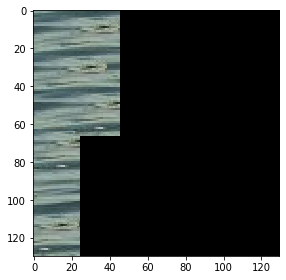

X 21
Y 63
6 31
7 32
10 35
11 36
12 37
14 39
17 42
18 43
19 44
20 45
21 46
22 47
23 48
31 56
32 57
33 58
34 59
35 60
36 61
37 62
38 63
39 64
40 65
42 67
43 68
44 69
45 70
46 71
47 72
48 73
51 76
52 77
53 78
54 79
55 80
56 81
57 82
58 83
59 84
60 85
61 86
62 87
63 88
64 89
65 90
66 91
67 92
68 93
69 94
70 95
71 96
72 97
73 98
74 99
75 100
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Right {31, 32, 35, 36, 37, 39, 42, 43, 44, 45, 46, 47, 48, 56, 57, 60, 61, 62, 64, 67, 68, 69, 70, 71, 72, 73, 81, 82, 85, 86, 87, 89, 92, 93, 94, 95, 96, 97, 98}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 54
MAPPING 79
MAPPING 5
MAPPING 30
MAPPING 

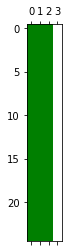

Patch Up [[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0

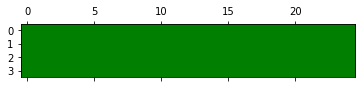

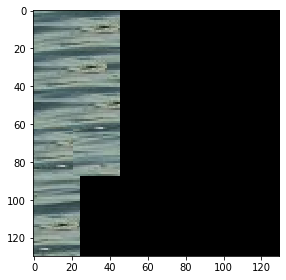

X 21
Y 84
1 26
2 27
3 28
4 29
5 30
7 32
10 35
11 36
13 38
14 39
15 40
16 41
18 43
19 44
20 45
21 46
22 47
23 48
24 49
25 50
31 56
32 57
33 58
35 60
36 61
38 63
39 64
40 65
41 66
42 67
43 68
44 69
45 70
46 71
47 72
48 73
49 74
50 75
59 84
60 85
61 86
62 87
63 88
64 89
65 90
66 91
67 92
68 93
69 94
70 95
71 96
72 97
73 98
74 99
75 100
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Right {26, 27, 28, 29, 30, 32, 35, 36, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 85, 86, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MA

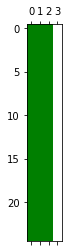

Patch Up [[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0

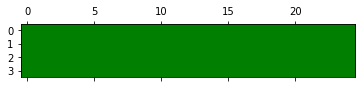

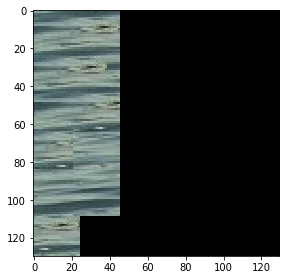

X 21
Y 105
1 26
2 27
3 28
4 29
5 30
6 31
7 32
8 33
9 34
11 36
12 37
13 38
14 39
15 40
16 41
17 42
18 43
19 44
20 45
21 46
22 47
23 48
24 49
25 50
37 62
38 63
39 64
40 65
41 66
42 67
43 68
44 69
45 70
46 71
47 72
48 73
49 74
50 75
60 85
61 86
62 87
63 88
64 89
65 90
66 91
67 92
68 93
69 94
70 95
71 96
72 97
73 98
74 99
75 100
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Right {26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPI

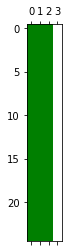

Patch Up [[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0

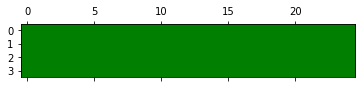

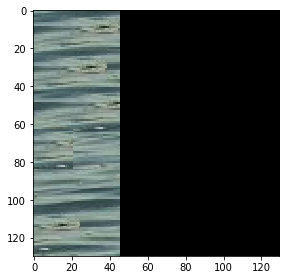

X 42
Y 0
Patch Up [[[0.43529412 0.50980392 0.50196078]
  [0.43137255 0.50588235 0.49803922]
  [0.43137255 0.50588235 0.49803922]
  [0.42745098 0.50588235 0.49803922]
  [0.38039216 0.48235294 0.47843137]
  [0.36078431 0.4745098  0.46666667]
  [0.34901961 0.4627451  0.45490196]
  [0.34509804 0.45882353 0.45098039]
  [0.32941176 0.44313725 0.43529412]
  [0.30588235 0.41960784 0.41176471]
  [0.30196078 0.41568627 0.40784314]
  [0.31372549 0.42745098 0.41960784]
  [0.27843137 0.39215686 0.38431373]
  [0.2745098  0.38823529 0.38039216]
  [0.26666667 0.38039216 0.37254902]
  [0.26666667 0.38039216 0.37254902]
  [0.26666667 0.38039216 0.37254902]
  [0.27058824 0.38431373 0.37647059]
  [0.27058824 0.38431373 0.37647059]
  [0.27058824 0.38431373 0.37647059]
  [0.26666667 0.36078431 0.36862745]
  [0.26666667 0.36078431 0.36862745]
  [0.26666667 0.36078431 0.36862745]
  [0.26666667 0.36078431 0.36862745]
  [0.26666667 0.36078431 0.36862745]]

 [[0.21568627 0.29411765 0.29019608]
  [0.22352941 0.30

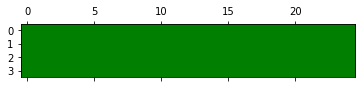

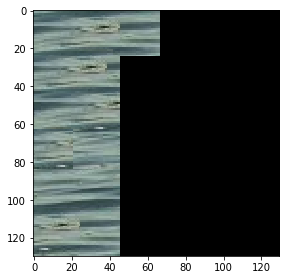

X 42
Y 21
1 26
2 27
3 28
4 29
6 31
8 33
9 34
10 35
11 36
14 39
17 42
18 43
19 44
20 45
31 56
32 57
33 58
34 59
35 60
36 61
39 64
44 69
45 70
49 74
55 80
56 57
56 81
62 87
63 88
64 89
65 90
66 91
67 92
68 93
69 94
70 95
71 96
72 97
73 98
74 99
75 100
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Right {26, 27, 28, 29, 31, 33, 34, 35, 36, 39, 42, 43, 44, 45, 51, 52, 53, 54, 56, 58, 59, 60, 61, 64, 67, 68, 69, 70, 76, 77, 78, 79, 81, 83, 84, 85, 86, 89, 92, 93, 94, 95}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 54
MAPPING 79
MAPPING 5
MAPPING 30
MAPPING 55
MAPPING 80
MAPPING 6
MAPPING 31
MAPPING 56
MAPPING 81
MAPPING 7
MAPPING 32

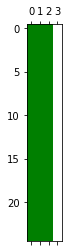

Patch Up [[[0.26666667 0.36078431 0.36862745]
  [0.26666667 0.36078431 0.36862745]
  [0.26666667 0.36078431 0.36862745]
  [0.26666667 0.36078431 0.36862745]
  [0.25882353 0.35294118 0.36078431]
  [0.25490196 0.34901961 0.35686275]
  [0.2627451  0.35686275 0.36470588]
  [0.27058824 0.36470588 0.37254902]
  [0.21960784 0.31372549 0.32156863]
  [0.23137255 0.3254902  0.33333333]
  [0.24705882 0.34117647 0.34901961]
  [0.25490196 0.34901961 0.35686275]
  [0.25098039 0.34509804 0.35294118]
  [0.24313725 0.3372549  0.34509804]
  [0.23529412 0.32941176 0.3372549 ]
  [0.22745098 0.32156863 0.32941176]
  [0.24313725 0.34117647 0.35686275]
  [0.23529412 0.33333333 0.34901961]
  [0.23137255 0.32941176 0.34901961]
  [0.24313725 0.3372549  0.35294118]
  [0.25098039 0.34117647 0.36470588]
  [0.25098039 0.34509804 0.36078431]
  [0.24313725 0.33333333 0.35686275]
  [0.23921569 0.33333333 0.34901961]
  [0.2745098  0.35294118 0.38039216]]

 [[0.29019608 0.38431373 0.4       ]
  [0.32941176 0.42352941 0.

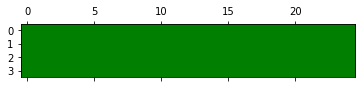

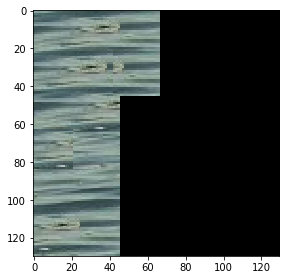

X 42
Y 42
1 26
2 27
3 28
22 47
48 73
49 74
54 79
75 100
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Right {97, 72, 76, 77, 78, 47, 51, 52, 53, 26, 27, 28}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 54
MAPPING 79
MAPPING 5
MAPPING 30
MAPPING 55
MAPPING 80
MAPPING 6
MAPPING 31
MAPPING 56
MAPPING 81
MAPPING 7
MAPPING 32
MAPPING 57
MAPPING 82
MAPPING 8
MAPPING 33
MAPPING 58
MAPPING 83
MAPPING 9
MAPPING 34
MAPPING 59
MAPPING 84
MAPPING 10
MAPPING 35
MAPPING 60
MAPPING 85
MAPPING 11
MAPPING 36
MAPPING 61
MAPPING 86
MAPPING 12
MAPPING 37
MAPPING 62
MAPPING 87
MAPPING 13
MAPPING 38
MAPPING 63
MAPPING 88
MAPPING 14
MAPPING 39
MAPPING

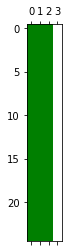

Patch Up [[[0.25882353 0.34117647 0.36078431]
  [0.25882353 0.34117647 0.36078431]
  [0.23529412 0.31764706 0.3372549 ]
  [0.21176471 0.29411765 0.31372549]
  [0.20392157 0.28235294 0.30980392]
  [0.21176471 0.29019608 0.31764706]
  [0.23529412 0.31764706 0.3372549 ]
  [0.23921569 0.32156863 0.34117647]
  [0.23921569 0.32156863 0.34117647]
  [0.24705882 0.32941176 0.34901961]
  [0.25882353 0.34117647 0.36078431]
  [0.27058824 0.35294118 0.37254902]
  [0.28627451 0.36862745 0.38823529]
  [0.29411765 0.37647059 0.39607843]
  [0.27058824 0.35294118 0.37254902]
  [0.28627451 0.36862745 0.38823529]
  [0.30196078 0.38431373 0.40392157]
  [0.31372549 0.39607843 0.41568627]
  [0.34117647 0.42352941 0.44313725]
  [0.37254902 0.45490196 0.4745098 ]
  [0.38431373 0.46666667 0.48627451]
  [0.37254902 0.45490196 0.46666667]
  [0.4        0.47843137 0.48235294]
  [0.41568627 0.49411765 0.49019608]
  [0.43529412 0.51372549 0.50980392]]

 [[0.19607843 0.27843137 0.28235294]
  [0.20392157 0.28627451 0.

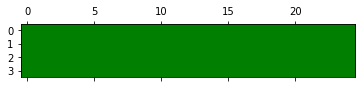

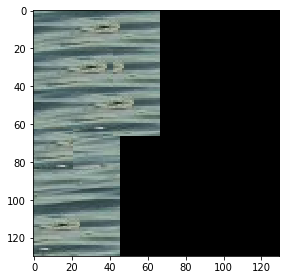

X 42
Y 63
1 26
2 27
3 28
4 29
5 30
6 31
7 32
8 33
10 35
13 38
14 39
15 40
16 41
17 42
18 43
20 45
21 46
22 47
23 48
24 49
25 50
35 60
36 61
37 62
38 63
39 64
40 65
41 66
42 67
43 68
46 71
47 72
48 73
49 74
50 75
59 84
60 61
60 85
69 94
70 95
71 96
72 97
73 74
73 98
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73}
Right {26, 27, 28, 29, 30, 31, 32, 33, 35, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 54
MAPPING 79
MAPPING 5
MAP

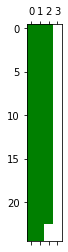

Patch Up [[[0.42352941 0.5372549  0.52941176]
  [0.41568627 0.5372549  0.51764706]
  [0.42352941 0.54509804 0.5254902 ]
  [0.43529412 0.55686275 0.5372549 ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.54509804 0.65098039 0.63137255]
  [0.54509804 0.65882353 0.

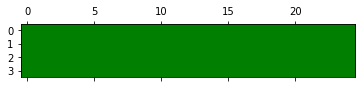

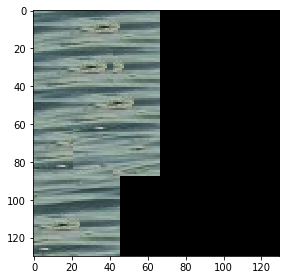

X 42
Y 84
1 26
2 27
3 28
4 29
5 30
6 31
7 32
8 33
9 34
10 35
11 36
12 37
13 38
14 39
15 40
16 41
17 42
18 43
19 44
20 45
21 46
22 47
23 48
24 49
75 100
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Right {26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 54
MAPPING 79
MAPPING 5
MAPPING 30
MAPPING 55
MAPPING 80
MAPPING 6
MAPPING 31
MAPPING 56
MAPPING 8

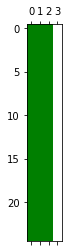

Patch Up [[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0

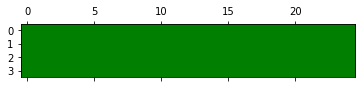

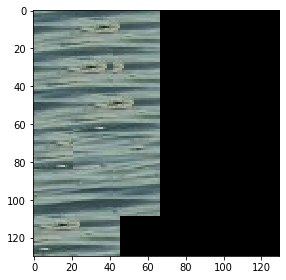

X 42
Y 105
1 26
2 27
3 28
4 29
5 30
6 31
7 32
8 33
9 34
10 35
11 36
14 39
15 40
16 41
17 42
18 43
21 46
22 47
23 48
24 49
25 50
38 63
39 64
40 65
41 66
42 67
44 69
45 70
46 71
47 72
48 73
49 74
50 75
62 87
63 88
64 89
65 90
66 91
67 92
68 93
69 94
70 95
71 96
72 97
73 98
74 99
75 100
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Right {26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 64, 65, 66, 67, 68, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 89, 90, 91, 92, 93, 96, 97, 98, 99, 100}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 

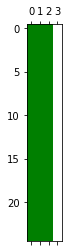

Patch Up [[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0

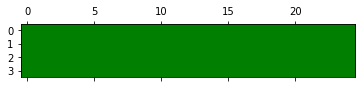

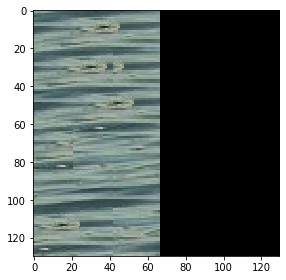

X 63
Y 0
Patch Up [[[0.28235294 0.39215686 0.40392157]
  [0.29019608 0.38431373 0.4       ]
  [0.32941176 0.42352941 0.43921569]
  [0.35294118 0.44705882 0.4627451 ]
  [0.33333333 0.42745098 0.43529412]
  [0.30588235 0.4        0.41568627]
  [0.29803922 0.39215686 0.4       ]
  [0.29411765 0.38823529 0.39607843]
  [0.28627451 0.38039216 0.38823529]
  [0.2745098  0.35686275 0.36862745]
  [0.28235294 0.36470588 0.37647059]
  [0.28627451 0.36862745 0.38039216]
  [0.2745098  0.35686275 0.36862745]
  [0.2627451  0.34509804 0.35686275]
  [0.25490196 0.3372549  0.34117647]
  [0.25882353 0.34117647 0.35294118]
  [0.2627451  0.35686275 0.36470588]
  [0.24313725 0.3372549  0.35294118]
  [0.2627451  0.36078431 0.38039216]
  [0.28627451 0.38431373 0.40392157]
  [0.29019608 0.38823529 0.40784314]
  [0.44705882 0.52941176 0.50196078]
  [0.45098039 0.53333333 0.50588235]
  [0.43921569 0.52156863 0.49411765]
  [0.37647059 0.45882353 0.43137255]]

 [[0.3254902  0.41568627 0.43921569]
  [0.32941176 0.42

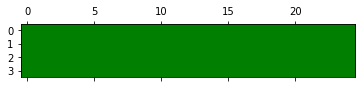

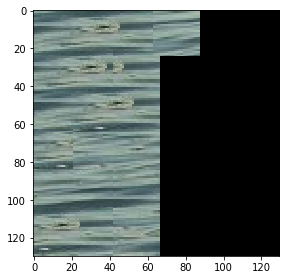

X 63
Y 21
1 26
2 27
3 28
4 29
8 33
10 35
11 36
12 37
13 38
14 39
15 40
16 41
18 43
19 44
20 45
21 46
22 47
23 48
24 49
25 50
31 56
32 57
33 58
34 59
35 60
36 61
37 62
38 63
39 40
39 64
43 68
45 46
48 73
49 74
55 80
56 81
57 82
58 83
59 84
60 85
61 86
62 87
63 88
64 65
64 89
67 92
68 93
69 94
70 95
71 96
72 97
73 98
74 99
75 100
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Right {26, 27, 28, 29, 33, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 58, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 83, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING

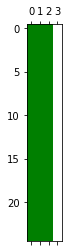

Patch Up [[[0.44705882 0.52941176 0.50196078]
  [0.45098039 0.53333333 0.50588235]
  [0.43921569 0.52156863 0.49411765]
  [0.37647059 0.45882353 0.43137255]
  [0.31764706 0.4        0.38039216]
  [0.25490196 0.3372549  0.31764706]
  [0.23921569 0.31764706 0.30980392]
  [0.23921569 0.31764706 0.31372549]
  [0.17647059 0.25490196 0.25098039]
  [0.18039216 0.25882353 0.2627451 ]
  [0.19215686 0.27058824 0.2745098 ]
  [0.20392157 0.27843137 0.29411765]
  [0.21176471 0.28627451 0.30196078]
  [0.22352941 0.29803922 0.32156863]
  [0.22745098 0.30196078 0.3254902 ]
  [0.22745098 0.30980392 0.32941176]
  [0.2        0.28235294 0.29411765]
  [0.20392157 0.28627451 0.29803922]
  [0.22352941 0.30588235 0.31764706]
  [0.2627451  0.34509804 0.35686275]
  [0.28627451 0.36862745 0.38039216]
  [0.29019608 0.37254902 0.38431373]
  [0.30196078 0.38431373 0.39607843]
  [0.32156863 0.40392157 0.41568627]
  [0.30980392 0.39215686 0.40392157]]

 [[0.32941176 0.41568627 0.40784314]
  [0.28627451 0.37254902 0.

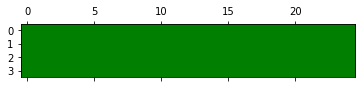

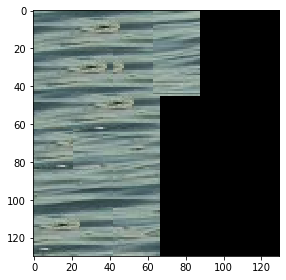

X 63
Y 42
2 27
3 28
4 29
5 30
6 31
7 32
8 33
10 35
11 36
12 37
13 38
14 39
15 40
16 41
17 42
18 43
19 44
20 45
21 46
22 47
23 48
24 49
25 50
30 55
31 56
32 57
33 58
35 36
35 60
51 76
52 77
53 78
54 79
55 80
56 81
57 82
58 83
59 84
60 61
60 85
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60}
Right {27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 54
MAPPING 79
MAPPING 5
MAPPING 30
MAPPING 55
MAPPING 80
MAPPING 6
MAPPING 31


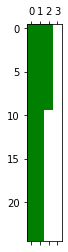

Patch Up [[[0.29019608 0.37254902 0.38431373]
  [0.30196078 0.38431373 0.39607843]
  [0.32156863 0.40392157 0.41568627]
  [0.30980392 0.39215686 0.40392157]
  [0.30980392 0.39215686 0.40392157]
  [0.31372549 0.39607843 0.40784314]
  [0.32156863 0.40392157 0.41568627]
  [0.32941176 0.41176471 0.42352941]
  [0.33333333 0.41568627 0.42745098]
  [0.3372549  0.41960784 0.43137255]
  [0.3372549  0.41960784 0.42352941]
  [0.36470588 0.45098039 0.43921569]
  [0.37254902 0.4627451  0.43921569]
  [0.37254902 0.4627451  0.43921569]
  [0.36470588 0.45490196 0.43137255]
  [0.37254902 0.4627451  0.43921569]
  [0.39215686 0.48235294 0.45882353]
  [0.39607843 0.48627451 0.4627451 ]
  [0.39215686 0.48235294 0.45882353]
  [0.43921569 0.52941176 0.50588235]
  [0.44313725 0.53333333 0.50980392]
  [0.46666667 0.55686275 0.53333333]
  [0.49803922 0.58823529 0.56470588]
  [0.52156863 0.61176471 0.58823529]
  [0.5372549  0.62745098 0.60392157]]

 [[0.37254902 0.46666667 0.4745098 ]
  [0.36862745 0.4627451  0.

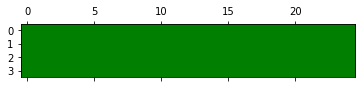

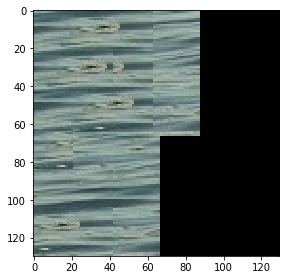

X 63
Y 63
1 26
3 28
4 29
22 47
23 48
25 50
28 53
29 54
52 77
53 78
54 79
74 99
75 100
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Right {97, 98, 100, 72, 73, 75, 76, 78, 79, 47, 48, 50, 51, 53, 54, 26, 28, 29}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 54
MAPPING 79
MAPPING 5
MAPPING 30
MAPPING 55
MAPPING 80
MAPPING 6
MAPPING 31
MAPPING 56
MAPPING 81
MAPPING 7
MAPPING 32
MAPPING 57
MAPPING 82
MAPPING 8
MAPPING 33
MAPPING 58
MAPPING 83
MAPPING 9
MAPPING 34
MAPPING 59
MAPPING 84
MAPPING 10
MAPPING 35
MAPPING 60
MAPPING 85
MAPPING 11
MAPPING 36
MAPPING 61
MAPPING 86
MAPPING 12
MAPPING 37
MAPPING 62
MAPPING 87
MAPPING 13
MAPPING

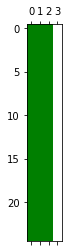

Patch Up [[[0.45490196 0.54117647 0.53333333]
  [0.45490196 0.54117647 0.53333333]
  [0.45490196 0.53333333 0.52941176]
  [0.45490196 0.53333333 0.52941176]
  [0.4627451  0.54117647 0.53333333]
  [0.47843137 0.55686275 0.54901961]
  [0.47843137 0.55294118 0.54509804]
  [0.47843137 0.55294118 0.54509804]
  [0.4745098  0.54901961 0.53333333]
  [0.43921569 0.51372549 0.49803922]
  [0.40784314 0.48235294 0.46666667]
  [0.41568627 0.49019608 0.4745098 ]
  [0.38823529 0.45098039 0.43921569]
  [0.38823529 0.45098039 0.43921569]
  [0.38431373 0.44705882 0.44313725]
  [0.36862745 0.43137255 0.42745098]
  [0.34509804 0.41960784 0.41176471]
  [0.33333333 0.40784314 0.4       ]
  [0.32941176 0.40392157 0.39607843]
  [0.32941176 0.40392157 0.39607843]
  [0.35294118 0.43137255 0.42745098]
  [0.32941176 0.40784314 0.40392157]
  [0.31764706 0.39607843 0.39215686]
  [0.3254902  0.40392157 0.4       ]
  [0.3372549  0.41568627 0.41960784]]

 [[0.49803922 0.57647059 0.56862745]
  [0.50588235 0.58431373 0.

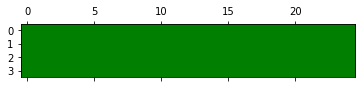

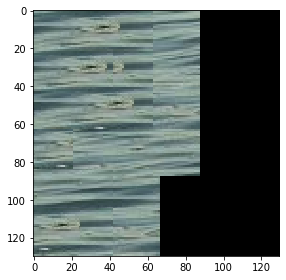

X 63
Y 84
2 27
3 28
4 29
5 30
6 31
7 32
9 34
10 35
11 36
12 37
13 38
14 39
15 40
16 41
17 42
18 43
19 44
20 45
21 46
23 48
24 49
26 51
27 52
28 29
28 53
33 58
34 59
35 60
36 37
36 61
47 72
48 73
49 74
50 75
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50}
Right {27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 54
MAPPING 79
MAPPING 5
MAPPING 30
MAPPING 55
MAPPING 80
MAPPING 6
MAPPING 31
MAPPING 56
MAPPING 81
MAPPING 7
MAPPING 32
MAPPING 57
MAPPING 82
MAPPING 8
MAPPING 33
MAPPING 58
MAPP

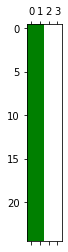

Patch Up [[[0.48235294 0.56470588 0.54509804]
  [0.43529412 0.51764706 0.49019608]
  [0.43529412 0.51764706 0.49019608]
  [0.45490196 0.5372549  0.50980392]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.56862745 0.64313725 0.61960784]
  [0.6        0.6745098  0.

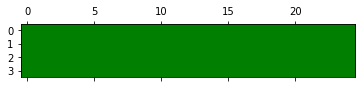

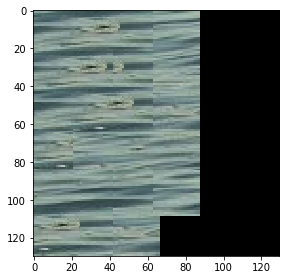

X 63
Y 105
1 26
2 27
3 28
4 29
5 30
6 31
7 32
8 33
9 34
10 35
11 36
12 37
13 38
14 39
15 40
16 41
20 45
21 46
22 47
23 48
24 49
25 50
45 70
46 71
47 72
48 73
49 74
50 75
67 92
68 93
69 94
70 95
71 96
72 97
73 98
74 99
75 100
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Right {26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 95, 96, 97, 98, 99, 100}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 54
MAPPING 79
MAPPING 5
MAPPING 30
MAPPING 55
MA

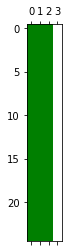

Patch Up [[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0

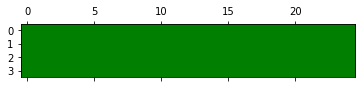

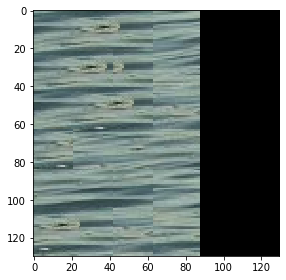

X 84
Y 0
Patch Up [[[0.50980392 0.58431373 0.56862745]
  [0.50196078 0.57647059 0.56078431]
  [0.42745098 0.50980392 0.49019608]
  [0.40784314 0.49019608 0.47058824]
  [0.38431373 0.46666667 0.44705882]
  [0.36470588 0.44705882 0.42745098]
  [0.35686275 0.43529412 0.42745098]
  [0.34117647 0.42745098 0.41568627]
  [0.3254902  0.41176471 0.4       ]
  [0.31764706 0.40392157 0.39215686]
  [0.34509804 0.42352941 0.41960784]
  [0.36470588 0.43529412 0.43529412]
  [0.36862745 0.43921569 0.43921569]
  [0.36470588 0.43529412 0.43529412]
  [0.37254902 0.44313725 0.44313725]
  [0.39215686 0.4627451  0.4627451 ]
  [0.4        0.47058824 0.47058824]
  [0.39607843 0.46666667 0.46666667]
  [0.39215686 0.4627451  0.4627451 ]
  [0.4        0.47058824 0.47058824]
  [0.40784314 0.47843137 0.47843137]
  [0.40392157 0.4745098  0.4745098 ]
  [0.4        0.47058824 0.47058824]
  [0.4        0.47058824 0.47058824]
  [0.41568627 0.48627451 0.48627451]]

 [[0.41568627 0.49019608 0.46666667]
  [0.40392157 0.47

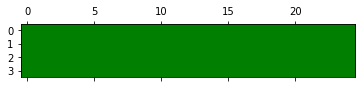

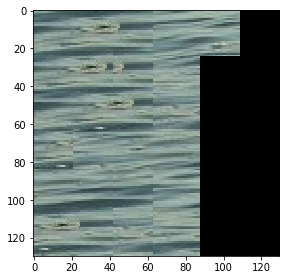

X 84
Y 21
1 26
2 27
3 28
4 29
9 34
10 35
11 36
12 37
13 38
14 39
15 40
16 41
17 42
18 43
19 44
20 45
21 46
22 47
23 48
24 49
30 55
31 56
32 57
33 58
34 59
35 60
36 61
37 62
38 63
39 64
40 65
41 42
41 66
50 75
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50}
Right {26, 27, 28, 29, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 54
MAPPING 79
MAPPING 5
MAPPING 30
MAPPING 55
MAPPING 80
MAPPING 6
MAPPING 31
MAPPING 56
MAPPING 81
MAPPING 7
MAPPING 32
MAPPING 57
MAPPING 82
MAPPING 8
MAPPING 33
MAPPING 58
MAPPING 83
MAP

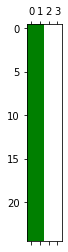

Patch Up [[[0.40392157 0.4745098  0.4745098 ]
  [0.4        0.47058824 0.47058824]
  [0.4        0.47058824 0.47058824]
  [0.41568627 0.48627451 0.48627451]
  [0.43137255 0.50588235 0.49803922]
  [0.45490196 0.5372549  0.50980392]
  [0.47058824 0.55294118 0.51764706]
  [0.43921569 0.52156863 0.48627451]
  [0.49411765 0.57647059 0.54117647]
  [0.4745098  0.55686275 0.52156863]
  [0.55294118 0.63529412 0.6       ]
  [0.55294118 0.63529412 0.6       ]
  [0.58823529 0.67058824 0.63529412]
  [0.56078431 0.64313725 0.60784314]
  [0.56470588 0.64705882 0.61176471]
  [0.57254902 0.65490196 0.61960784]
  [0.57647059 0.65882353 0.62352941]
  [0.57254902 0.65490196 0.61960784]
  [0.56862745 0.65098039 0.61568627]
  [0.56078431 0.64313725 0.60784314]
  [0.55294118 0.64313725 0.61176471]
  [0.57647059 0.65882353 0.62352941]
  [0.57254902 0.65490196 0.61960784]
  [0.56862745 0.65098039 0.61568627]
  [0.56078431 0.64313725 0.60784314]]

 [[0.55686275 0.62745098 0.62745098]
  [0.54117647 0.61176471 0.

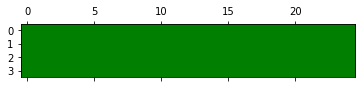

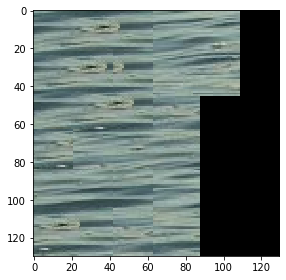

X 84
Y 42
1 26
2 27
4 29
6 31
7 32
8 33
9 34
10 35
11 36
12 37
13 38
14 39
15 40
16 41
17 42
20 45
23 48
24 49
29 54
30 55
31 56
32 57
33 58
34 59
35 60
36 61
37 62
38 63
39 64
40 65
41 66
42 67
45 70
46 71
47 72
48 49
48 73
53 78
54 79
55 80
56 81
57 82
58 59
58 83
68 93
69 94
70 95
71 96
72 73
72 97
75 100
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Right {26, 27, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 48, 49, 51, 52, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 70, 73, 74, 76, 77, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 98, 99}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 54
MAPPING 7

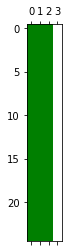

Patch Up [[[0.57647059 0.65882353 0.62352941]
  [0.57254902 0.65490196 0.61960784]
  [0.56862745 0.65098039 0.61568627]
  [0.56078431 0.64313725 0.60784314]
  [0.55294118 0.64313725 0.61176471]
  [0.48627451 0.57647059 0.55294118]
  [0.4745098  0.57254902 0.55686275]
  [0.4745098  0.57254902 0.55686275]
  [0.4745098  0.57254902 0.55686275]
  [0.47058824 0.56862745 0.55294118]
  [0.47058824 0.56862745 0.55294118]
  [0.4745098  0.57254902 0.55686275]
  [0.4745098  0.57254902 0.55686275]
  [0.45882353 0.55686275 0.54117647]
  [0.47058824 0.56862745 0.55294118]
  [0.4745098  0.57254902 0.55686275]
  [0.46666667 0.56470588 0.54901961]
  [0.46666667 0.56470588 0.54901961]
  [0.4745098  0.57254902 0.55686275]
  [0.4745098  0.57254902 0.55686275]
  [0.47058824 0.55686275 0.54509804]
  [0.37647059 0.4745098  0.45098039]
  [0.39215686 0.49019608 0.46666667]
  [0.40784314 0.50588235 0.48235294]
  [0.41960784 0.51764706 0.49411765]]

 [[0.48627451 0.57647059 0.54509804]
  [0.45098039 0.54117647 0.

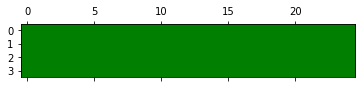

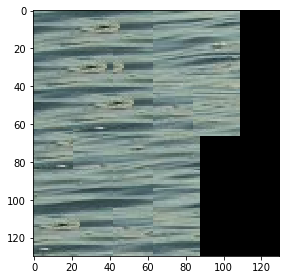

X 84
Y 63
1 26
2 27
3 28
4 29
5 30
7 32
9 34
10 35
11 36
12 37
13 38
14 39
15 40
16 41
17 42
18 43
19 44
20 45
21 46
23 48
24 49
25 50
31 56
32 57
33 58
34 59
35 60
36 37
36 61
48 73
50 75
72 97
73 98
74 99
75 100
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Right {26, 27, 28, 29, 30, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99, 100}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 54
MAPPING 79
MAPPING 5
MAPPING 30
MAPPING 55
MAPPING 80
MA

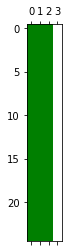

Patch Up [[[0.37647059 0.4745098  0.45098039]
  [0.39215686 0.49019608 0.46666667]
  [0.40784314 0.50588235 0.48235294]
  [0.41960784 0.51764706 0.49411765]
  [0.42745098 0.5254902  0.50196078]
  [0.43529412 0.53333333 0.50980392]
  [0.42352941 0.52156863 0.49803922]
  [0.41960784 0.51764706 0.49411765]
  [0.41960784 0.51764706 0.49411765]
  [0.43137255 0.52941176 0.50588235]
  [0.45098039 0.54901961 0.5254902 ]
  [0.48235294 0.58039216 0.55686275]
  [0.51372549 0.61176471 0.58823529]
  [0.53333333 0.63137255 0.60784314]
  [0.56470588 0.65490196 0.63137255]
  [0.56862745 0.65490196 0.64313725]
  [0.57647059 0.6627451  0.65098039]
  [0.58431373 0.67058824 0.65882353]
  [0.58431373 0.67058824 0.65882353]
  [0.56470588 0.65098039 0.64313725]
  [0.52941176 0.61568627 0.60784314]
  [0.50588235 0.59215686 0.58431373]
  [0.37254902 0.45882353 0.45098039]
  [0.33333333 0.41568627 0.41960784]
  [0.2745098  0.35686275 0.36078431]]

 [[0.50980392 0.6        0.56862745]
  [0.51764706 0.60784314 0.

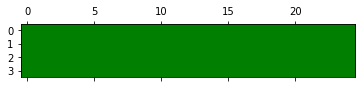

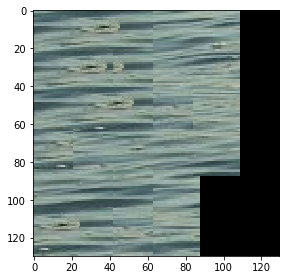

X 84
Y 84
1 26
2 27
3 28
4 29
5 30
6 31
7 32
8 33
9 34
12 37
14 39
16 41
17 42
18 43
19 44
24 49
35 60
36 61
37 62
38 63
39 64
40 65
41 66
42 43
42 67
50 75
70 95
71 96
72 97
73 98
74 99
75 100
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Right {26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 39, 41, 42, 43, 44, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 64, 66, 67, 68, 69, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 87, 89, 91, 92, 93, 94, 99}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 54
MAPPING 79
MAPPING 5
MAPPING 30
MAPPING 55
MAPPING 80
MAPPING 6
MAPPING 31
MAPPING 56
MAPPING 81
MAPPING 7
MAPPING 32
MAPPING 57
MAPPING 82
MAPPING 8

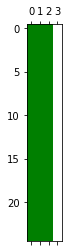

Patch Up [[[0.59215686 0.67058824 0.6627451 ]
  [0.58823529 0.67058824 0.65098039]
  [0.53333333 0.61960784 0.60784314]
  [0.5254902  0.62352941 0.60784314]
  [0.52941176 0.62745098 0.61176471]
  [0.54509804 0.64313725 0.62745098]
  [0.55686275 0.65490196 0.63921569]
  [0.55294118 0.65098039 0.63529412]
  [0.5372549  0.63529412 0.61960784]
  [0.52156863 0.61960784 0.60784314]
  [0.50196078 0.6        0.58823529]
  [0.49803922 0.59607843 0.58431373]
  [0.49019608 0.58431373 0.58431373]
  [0.4745098  0.56862745 0.56862745]
  [0.4627451  0.55686275 0.55686275]
  [0.45098039 0.54509804 0.54509804]
  [0.43921569 0.53333333 0.53333333]
  [0.43529412 0.52941176 0.5372549 ]
  [0.44313725 0.5372549  0.54509804]
  [0.43137255 0.5254902  0.53333333]
  [0.42352941 0.51764706 0.5254902 ]
  [0.42352941 0.51764706 0.5254902 ]
  [0.43529412 0.52941176 0.5372549 ]
  [0.44705882 0.54117647 0.54901961]
  [0.45098039 0.54509804 0.56078431]]

 [[0.61960784 0.70196078 0.68235294]
  [0.61568627 0.69803922 0.

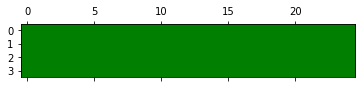

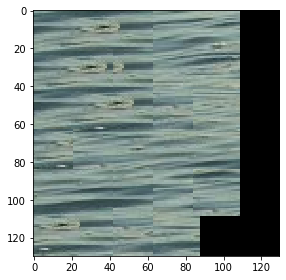

X 84
Y 105
4 29
5 30
6 31
7 32
8 33
11 36
12 37
13 38
14 39
15 40
16 41
17 42
18 43
19 44
20 45
21 46
22 47
23 48
24 49
25 50
29 54
30 55
31 56
32 57
33 58
35 60
37 62
38 63
39 64
40 41
40 65
51 76
52 77
53 78
54 79
55 80
56 57
56 81
59 84
60 85
61 86
62 87
63 64
63 88
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63}
Right {29, 30, 31, 32, 33, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 56, 57, 58, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 79, 80, 81, 82, 83, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 54
MAPPING 79
MAPPING 5
MAPPING 30
MAPPING 55
MAPPING 80
MAPPING 6
MAPPING 

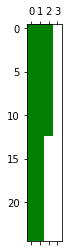

Patch Up [[[0.61568627 0.67843137 0.63921569]
  [0.61960784 0.68235294 0.64313725]
  [0.61568627 0.67843137 0.63921569]
  [0.6        0.6627451  0.62352941]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.51372549 0.58039216 0.55686275]
  [0.54117647 0.60784314 0.

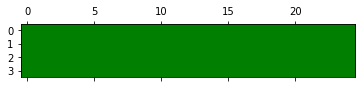

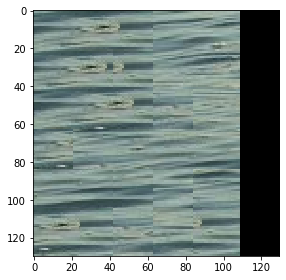

X 105
Y 0
Patch Up [[[0.25490196 0.35294118 0.34117647]
  [0.25490196 0.35294118 0.34117647]
  [0.25490196 0.35294118 0.34117647]
  [0.25490196 0.35294118 0.34117647]
  [0.25490196 0.35294118 0.34117647]
  [0.24313725 0.34117647 0.32941176]
  [0.22745098 0.3254902  0.31372549]
  [0.21568627 0.31372549 0.30196078]
  [0.23529412 0.33333333 0.32156863]
  [0.21960784 0.31764706 0.30588235]
  [0.2        0.29411765 0.29411765]
  [0.20784314 0.29411765 0.28627451]
  [0.22352941 0.30588235 0.30980392]
  [0.23921569 0.3254902  0.31764706]
  [0.24313725 0.3254902  0.32941176]
  [0.24313725 0.32941176 0.32156863]
  [0.24705882 0.3254902  0.32941176]
  [0.25098039 0.32941176 0.3254902 ]
  [0.25490196 0.33333333 0.3372549 ]
  [0.25882353 0.3372549  0.33333333]
  [0.26666667 0.34509804 0.34901961]
  [0.26666667 0.34509804 0.34901961]
  [0.27843137 0.34901961 0.34901961]
  [0.28627451 0.35686275 0.36470588]
  [0.29019608 0.36078431 0.36862745]]

 [[0.21960784 0.31372549 0.32156863]
  [0.23137255 0.3

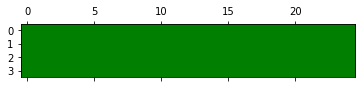

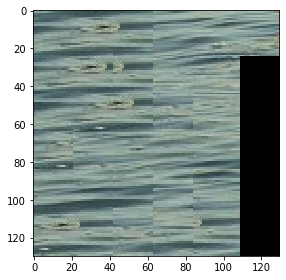

X 105
Y 21
1 26
2 27
3 28
4 29
5 30
8 33
10 35
14 39
15 40
16 41
17 42
18 43
19 44
20 45
21 46
33 58
34 59
35 60
36 61
37 62
39 40
39 64
56 81
57 58
57 82
63 88
64 65
64 89
72 97
73 98
74 99
75 100
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Right {26, 27, 28, 29, 30, 33, 35, 39, 40, 41, 42, 43, 44, 45, 46, 51, 52, 53, 54, 55, 58, 60, 64, 65, 66, 67, 68, 69, 70, 71, 76, 77, 78, 79, 80, 83, 85, 89, 90, 91, 92, 93, 94, 95, 96}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 54
MAPPING 79
MAPPING 5
MAPPING 30
MAPPING 55
MAPPING 80
MAPPING 6
MAPPING 31
MAPPING 56
MAPPING 81
MAPPING 7
MAPPING 32
MAPPING 57
MAPPING 82
MAPPING 8
MAPPING

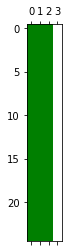

Patch Up [[[0.26666667 0.34509804 0.34901961]
  [0.27843137 0.34901961 0.34901961]
  [0.28627451 0.35686275 0.36470588]
  [0.29019608 0.36078431 0.36862745]
  [0.26666667 0.3372549  0.34509804]
  [0.27843137 0.34901961 0.35686275]
  [0.29803922 0.36862745 0.37647059]
  [0.30980392 0.38823529 0.39215686]
  [0.31372549 0.39215686 0.39607843]
  [0.30588235 0.38823529 0.39215686]
  [0.30588235 0.38823529 0.39215686]
  [0.30196078 0.4        0.38823529]
  [0.2745098  0.37254902 0.36078431]
  [0.28627451 0.39215686 0.37254902]
  [0.30980392 0.41176471 0.4       ]
  [0.32156863 0.43529412 0.41568627]
  [0.3372549  0.45098039 0.43137255]
  [0.34509804 0.45882353 0.43921569]
  [0.35294118 0.46666667 0.44705882]
  [0.36078431 0.4745098  0.45490196]
  [0.38823529 0.48627451 0.4745098 ]
  [0.61568627 0.69019608 0.66666667]
  [0.60784314 0.68235294 0.66666667]
  [0.59215686 0.66666667 0.65098039]
  [0.58039216 0.65490196 0.63921569]]

 [[0.31764706 0.39607843 0.42352941]
  [0.32941176 0.40392157 0.

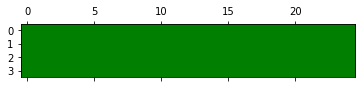

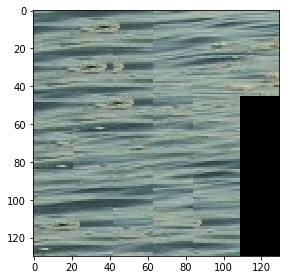

X 105
Y 42
1 26
2 27
3 28
4 29
5 30
6 31
7 32
10 35
11 36
12 37
15 40
16 41
20 45
21 46
22 47
23 48
24 49
25 50
35 60
36 61
37 62
39 64
40 65
41 66
43 68
45 70
47 72
48 73
49 74
50 75
58 83
59 84
60 85
61 86
62 87
63 64
63 88
67 92
68 93
69 94
70 95
71 96
72 97
73 98
74 99
75 100
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Right {26, 27, 28, 29, 30, 31, 32, 35, 36, 37, 40, 41, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 60, 61, 62, 65, 66, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85, 86, 87, 90, 91, 95, 96, 97, 98, 99, 100}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 54
MAPPING 79
MAPPING 5
MAPPING 30
MAPPI

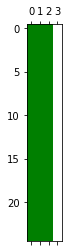

Patch Up [[[0.61568627 0.69019608 0.66666667]
  [0.60784314 0.68235294 0.66666667]
  [0.59215686 0.66666667 0.65098039]
  [0.58039216 0.65490196 0.63921569]
  [0.57254902 0.64705882 0.63137255]
  [0.57254902 0.64705882 0.63137255]
  [0.57647059 0.65098039 0.63529412]
  [0.55294118 0.63529412 0.61568627]
  [0.54509804 0.62745098 0.60784314]
  [0.5372549  0.61960784 0.6       ]
  [0.53333333 0.61568627 0.59607843]
  [0.5372549  0.61960784 0.6       ]
  [0.53333333 0.61568627 0.59607843]
  [0.5254902  0.60784314 0.58823529]
  [0.51764706 0.6        0.58039216]
  [0.54901961 0.63137255 0.61176471]
  [0.55294118 0.63529412 0.61568627]
  [0.55686275 0.63921569 0.61960784]
  [0.56470588 0.64705882 0.62745098]
  [0.57647059 0.65882353 0.63921569]
  [0.59215686 0.6745098  0.65490196]
  [0.4745098  0.54509804 0.49803922]
  [0.47843137 0.54901961 0.50196078]
  [0.50196078 0.57254902 0.5254902 ]
  [0.52156863 0.59215686 0.54509804]]

 [[0.52941176 0.60392157 0.58823529]
  [0.52156863 0.59607843 0.

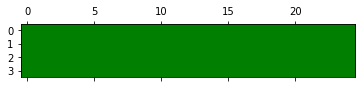

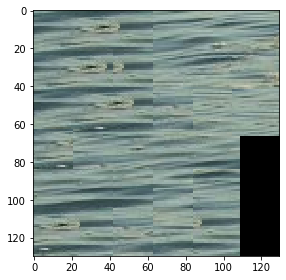

X 105
Y 63
2 27
3 28
4 29
5 30
6 31
7 32
8 33
9 34
10 35
11 36
12 37
13 38
14 39
15 40
16 41
23 48
24 49
27 52
28 29
28 53
47 72
48 73
51 52
51 76
67 92
68 93
69 94
70 95
71 96
72 97
73 98
74 99
75 100
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Right {27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 48, 49, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 73, 74, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 98, 99}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 54
MAPPING 79
MAPPING 5
MAPPING 30
MAPPING 55
MAPPING 80
MAPPING 6
MAPPING 31
MAPPING 56
MAPPING 81
MAPPING 7
MAPPING 32
MAPPING 57


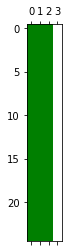

Patch Up [[[0.4745098  0.54509804 0.49803922]
  [0.47843137 0.54901961 0.50196078]
  [0.50196078 0.57254902 0.5254902 ]
  [0.52156863 0.59215686 0.54509804]
  [0.51372549 0.58039216 0.54117647]
  [0.51372549 0.58039216 0.54117647]
  [0.50588235 0.57254902 0.54117647]
  [0.49019608 0.56862745 0.53333333]
  [0.48627451 0.55294118 0.52156863]
  [0.4627451  0.54117647 0.50588235]
  [0.45098039 0.52941176 0.49411765]
  [0.44313725 0.51764706 0.49411765]
  [0.44313725 0.51764706 0.49411765]
  [0.44705882 0.52941176 0.50196078]
  [0.45098039 0.53333333 0.50588235]
  [0.44705882 0.52941176 0.50196078]
  [0.45098039 0.53333333 0.51372549]
  [0.45882353 0.54117647 0.52156863]
  [0.47058824 0.55294118 0.53333333]
  [0.4745098  0.56470588 0.53333333]
  [0.47843137 0.56862745 0.5372549 ]
  [0.31372549 0.39607843 0.41568627]
  [0.31764706 0.39607843 0.42352941]
  [0.32941176 0.40392157 0.42745098]
  [0.3372549  0.41176471 0.43921569]]

 [[0.50588235 0.57647059 0.52156863]
  [0.50980392 0.58039216 0.

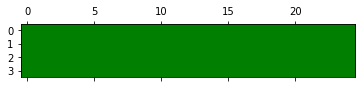

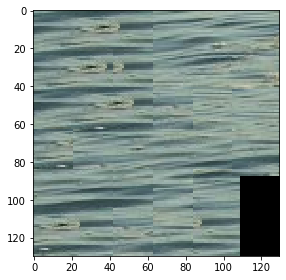

X 105
Y 84
1 26
4 29
5 30
6 31
7 32
8 33
11 36
12 37
13 38
14 39
15 40
16 41
17 42
18 43
19 44
20 45
21 46
22 47
23 48
24 49
25 50
29 54
30 55
31 56
32 57
33 58
35 60
36 61
37 62
38 63
39 40
39 64
52 77
53 78
54 79
55 80
56 57
56 81
59 84
60 85
61 86
62 87
63 64
63 88
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63}
Right {26, 29, 30, 31, 32, 33, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 54
MAPPING 79
MAPPING 5
MAPPING 30
MAPPING 55
MAPPING 80
MAPPING

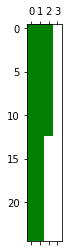

Patch Up [[[0.31372549 0.39607843 0.41568627]
  [0.31764706 0.39607843 0.42352941]
  [0.32941176 0.40392157 0.42745098]
  [0.3372549  0.41176471 0.43921569]
  [0.34117647 0.41568627 0.43921569]
  [0.42352941 0.49803922 0.52156863]
  [0.41960784 0.49411765 0.51764706]
  [0.41176471 0.48627451 0.50980392]
  [0.40392157 0.47843137 0.50196078]
  [0.4        0.4745098  0.49019608]
  [0.40392157 0.48627451 0.49803922]
  [0.42352941 0.50588235 0.51764706]
  [0.42352941 0.51764706 0.51764706]
  [0.43921569 0.53333333 0.53333333]
  [0.43529412 0.5372549  0.5254902 ]
  [0.42352941 0.5372549  0.52941176]
  [0.41568627 0.5372549  0.51764706]
  [0.42352941 0.54509804 0.5254902 ]
  [0.43529412 0.55686275 0.5372549 ]
  [0.45882353 0.58039216 0.56078431]
  [0.47843137 0.59215686 0.57254902]
  [0.45490196 0.54117647 0.52941176]
  [0.4745098  0.55294118 0.54509804]
  [0.49411765 0.57254902 0.56470588]
  [0.50588235 0.58431373 0.57647059]]

 [[0.43529412 0.51764706 0.5372549 ]
  [0.4627451  0.5372549  0.

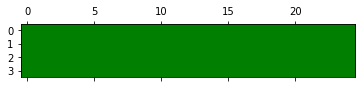

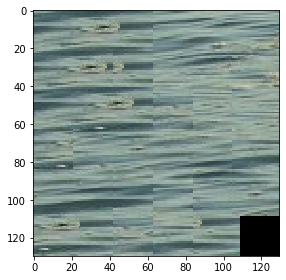

X 105
Y 105
4 29
6 31
7 32
8 33
12 37
18 43
23 48
24 49
25 50
26 51
27 52
28 53
29 54
31 56
32 57
33 58
37 62
39 64
40 65
41 66
42 67
43 68
46 71
49 74
50 75
55 80
56 81
57 82
58 83
59 84
60 85
61 86
62 87
63 88
64 89
65 90
66 91
67 68
67 92
69 94
70 95
71 96
72 97
73 98
74 99
75 100
left {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Right {29, 31, 32, 33, 37, 43, 48, 49, 50, 54, 56, 57, 58, 62, 68, 73, 74, 75, 79, 81, 82, 83, 87, 93, 98, 99, 100}
MAPPING 1
MAPPING 26
MAPPING 51
MAPPING 76
MAPPING 2
MAPPING 27
MAPPING 52
MAPPING 77
MAPPING 3
MAPPING 28
MAPPING 53
MAPPING 78
MAPPING 4
MAPPING 29
MAPPING 54
MAPPING 79
MAPPING 5
MAPPING 30
MAPPING 55
MAPPING 80
MAPPING 6
MAPPING 31
MAPPING 56
MAPPING 81
MAPPING 7
MAPPING 32
MAPPING 57
MAPPING 82
M

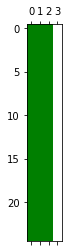

Patch Up [[[0.55686275 0.64313725 0.63137255]
  [0.58431373 0.67058824 0.65882353]
  [0.57254902 0.65882353 0.64705882]
  [0.57254902 0.67058824 0.65490196]
  [0.59215686 0.67843137 0.67058824]
  [0.59215686 0.69019608 0.67843137]
  [0.59607843 0.68235294 0.6745098 ]
  [0.56470588 0.6627451  0.65098039]
  [0.52941176 0.62745098 0.61568627]
  [0.50980392 0.60784314 0.59215686]
  [0.50980392 0.59215686 0.56470588]
  [0.51372549 0.59607843 0.56078431]
  [0.52156863 0.60392157 0.56862745]
  [0.54117647 0.62352941 0.58823529]
  [0.58431373 0.66666667 0.63921569]
  [0.61960784 0.69411765 0.67058824]
  [0.61568627 0.69019608 0.66666667]
  [0.59215686 0.66666667 0.65098039]
  [0.57647059 0.65098039 0.63529412]
  [0.55686275 0.63137255 0.62352941]
  [0.51764706 0.59215686 0.58431373]
  [0.4745098  0.54901961 0.54117647]
  [0.43529412 0.50588235 0.50588235]
  [0.40392157 0.4745098  0.4745098 ]
  [0.38431373 0.45490196 0.45490196]]

 [[0.54509804 0.61960784 0.59607843]
  [0.5372549  0.61176471 0.

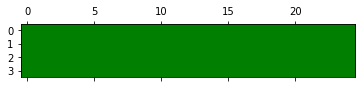

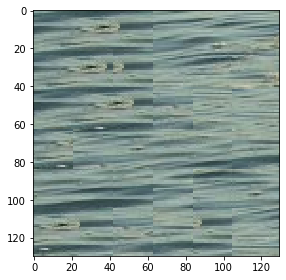

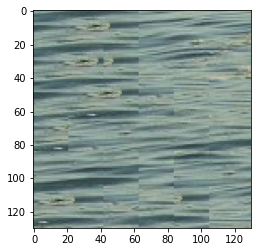

In [77]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('/content/ocean.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img = quilt(img, 25, (6, 6), "cut")
plt.imshow(img)